## Modified Slim

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
import os
import deepxde as dde
from utils.gs_solovev_sol import GS_Linear


######################
# ITER Configuration #
######################
A = -0.155
eps = 0.32
kappa = 1.7
delta = 0.33

N1 = - (1 + np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N2 = (1 - np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N3 = - kappa / (eps * np.cos(np.arcsin(delta)) ** 2)

def gen_traindata(num):
    ######################
    # ITER Configuration #
    ######################
    eps = 0.32
    kappa = 1.7
    delta = 0.33
    N = num
    center, eps, kappa, delta = np.array([[0.0,0.0]]), eps, kappa, delta
    tau = np.linspace(0, 2 * np.pi, N)
    # Define boundary of ellipse
    x_ellipse = np.asarray([1 + eps * np.cos(tau + np.arcsin(delta) * np.sin(tau)), 
                    eps * kappa * np.sin(tau)]).T
    xvals = x_ellipse
    uvals = np.zeros(len(xvals)).reshape(len(xvals), 1)
    return xvals, uvals


def pde_solovev(x, u):
    psi = u[:, 0:1]
    psi_r = dde.grad.jacobian(psi, x, i=0, j=0)
    psi_rr = dde.grad.hessian(psi, x, i=0, j=0)
    psi_zz = dde.grad.hessian(psi, x, i=1, j=1)
    GS = psi_rr - psi_r / x[:, 0:1] + psi_zz - (1 - A) * x[:, 0:1] ** 2 - A
    return GS

def psi_r(x,u):
    return dde.grad.jacobian(u, x, i=0, j=0)
def psi_z(x,u):
    return  dde.grad.jacobian(u, x, i=0, j=1)
def psi_rr(x, u):
    return dde.grad.hessian(u, x, i=0, j=0)
def psi_zz(x, u):
    return dde.grad.hessian(u, x, i=1, j=1)

def boundary_outer(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 + eps, 0]).all()
def boundary_inner(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - eps, 0]).all()
def boundary_high(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - delta * eps, kappa * eps]).all()

spatial_domain = dde.geometry.Ellipse(eps, kappa, delta) 

x,u = gen_traindata(1001)

n_test = 100

# specify psi, psi_r, psi_z, psi_rr, psi_zz at four locations 

observe_x = np.asarray([[1 + eps, 0], 
                        [1 - eps, 0], 
                        [1 - delta * eps, kappa * eps],
                        [1 - delta * eps, -kappa * eps]]
                    )
observe_y = np.asarray([0.0, 0.0, 0.0,0.0]).reshape(4, 1)

observe_x = np.concatenate((x,observe_x))
observe_y = np.concatenate((u,observe_y))

bc135 = dde.PointSetBC(x,u)

data = dde.data.PDE(
    spatial_domain,
    pde_solovev,
    [bc135],
    num_domain=1024,
    num_boundary=0,
    num_test=n_test,
    train_distribution="LHS"
)

# net = dde.maps.FNN([2] + 4 * [40] + [1], "tanh", "Glorot normal")

# model = dde.Model(data, net)


Using backend: tensorflow.compat.v1

2023-02-27 20:47:24.142249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term



Text(0, 0.5, '$u(r,z=0)$')

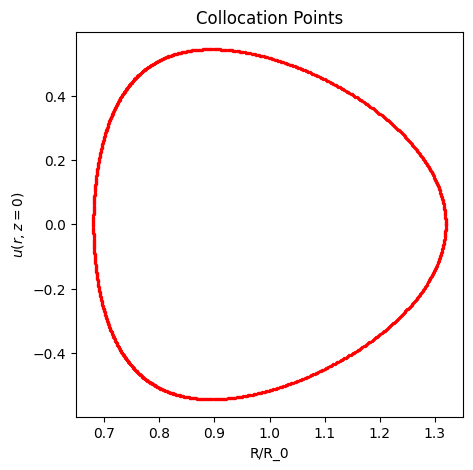

In [2]:
# Plot collocation points for visual check
fig,ax=plt.subplots(1, figsize=(5,5))
ax.scatter(data.train_x_bc[:,0], data.train_x_bc[:,1], s = 2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

## Train Model

Compiling model...
Building feed-forward neural network...
'build' took 0.078288 s



/Users/chrisjang/Documents/UMD/Research/MHD/PINN/alan_copy/deepxde_copy/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-02-27 20:47:37.058801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'compile' took 2.380678 s

Initializing variables...
Training model...



2023-02-27 20:47:39.404493: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


Step      Train loss              Test loss               Test metric
0         [1.07e+00, 2.19e-02]    [9.88e-01, 2.19e-02]    []  
1         [6.78e-01, 6.76e+00]    [6.13e-01, 6.76e+00]    []  
2         [8.81e-01, 5.39e-01]    [8.09e-01, 5.39e-01]    []  
3         [1.07e+00, 7.05e-01]    [9.93e-01, 7.05e-01]    []  
4         [1.11e+00, 1.74e+00]    [1.03e+00, 1.74e+00]    []  
5         [1.05e+00, 1.04e+00]    [9.72e-01, 1.04e+00]    []  
6         [9.56e-01, 1.96e-01]    [8.80e-01, 1.96e-01]    []  
7         [8.62e-01, 4.48e-02]    [7.89e-01, 4.48e-02]    []  
8         [7.86e-01, 4.45e-01]    [7.16e-01, 4.45e-01]    []  
9         [7.48e-01, 6.45e-01]    [6.79e-01, 6.45e-01]    []  
10        [7.41e-01, 4.26e-01]    [6.73e-01, 4.26e-01]    []  
11        [7.50e-01, 1.28e-01]    [6.82e-01, 1.28e-01]    []  
12        [7.61e-01, 2.00e-02]    [6.92e-01, 2.00e-02]    []  
13        [7.64e-01, 1.14e-01]    [6.95e-01, 1.14e-01]    []  
14        [7.52e-01, 2.54e-01]    [6.84e-01, 2.5

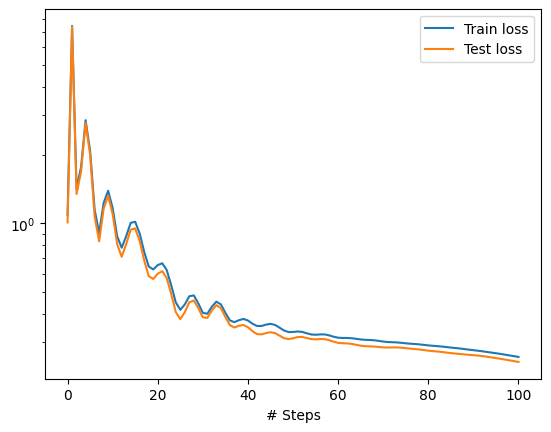

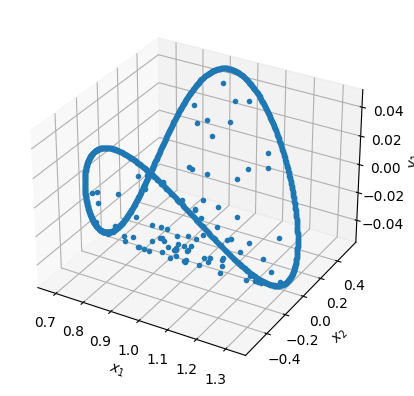

Accuracy
Mean residual: 0.41861495


In [3]:
DATE = "02272023"
CONFIG = "ITER"
LR = 2e-2
DROPOUT = 0.1
DEPTH = 3
BREADTH = 20
LOSSRATIO = 100
run = f"02_{LOSSRATIO}Adam_BFGS"
AF = "swish"
RUN_NAME = f"network_sweep_{DATE}_depth0{DEPTH}_breadth{BREADTH}_{AF}_lr{LR}-varying-short_lw1-10_{run}"
PATH = f"./cefron/{CONFIG}/runs/{RUN_NAME}"

# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN(
    [2] + DEPTH * [BREADTH] + [1], AF, "Glorot normal",
    #dropout_rate=DROPOUT
)

model = dde.Model(data, net)
decay_rate = 1.0
for i in range(1):
  # Compile, train and save model
  model.compile(
      "adam", lr=LR/(decay_rate*(i+1)),
      loss_weights=[1,LOSSRATIO]
  )
  loss_history, train_state = model.train(
      epochs=100, display_every=1, #callbacks=[dde.callbacks.DropoutUncertainty()]
  )
  dde.saveplot(
      loss_history, 
      train_state, 
      issave=True, 
      isplot=True,
      output_dir=PATH
  )

# make mesh
nx = 100
ny = 100
zoom = ((1 + eps)-(1 - eps))*0.05
innerPoint = 1 - eps - zoom
outerPoint = 1 + eps + zoom
lowPoint   = -kappa * eps - zoom
highPoint  = kappa * eps + zoom
x, y = np.meshgrid(
    np.linspace(innerPoint, outerPoint, nx),
    np.linspace(lowPoint, highPoint, ny),
)
X = np.vstack((np.ravel(x), np.ravel(y))).T
output = model.predict(X)
GS = model.predict(X, operator=pde_solovev)
residual_psi = np.mean(np.absolute(GS))

print("Accuracy")
print("Mean residual:", residual_psi)

## Plotting

#### Before BFGS

In [4]:
# Evaluation
from utils.utils import *
ITER = GS_Linear(eps=0.32, kappa=1.7, delta=0.33)
ITER.get_BCs(A)
ITER.solve_coefficients()
X_test = spatial_domain.random_points(333)
plot_summary_figure(ITER, model, X_test=X_test, losshistory = loss_history, loss_ratio = LOSSRATIO, PATH = PATH)

SyntaxError: invalid syntax (utils.py, line 431)

#### After BFGS

Compiling model...
'compile' took 2.261690 s

Training model...

Step      Train loss              Test loss               Test metric
100       [4.42e-03, 4.07e-03]    [4.24e-03, 4.07e-03]    []  
110       [9.28e-04, 1.91e-03]    [9.28e-04, 1.91e-03]        
120       [5.97e-04, 1.43e-03]    [5.97e-04, 1.43e-03]        
130       [5.44e-04, 7.48e-04]    [5.44e-04, 7.48e-04]        
140       [6.66e-04, 2.51e-04]    [6.66e-04, 2.51e-04]        
150       [4.29e-04, 1.71e-04]    [4.29e-04, 1.71e-04]        
160       [3.35e-04, 1.22e-04]    [3.35e-04, 1.22e-04]        
170       [3.27e-04, 3.49e-05]    [3.27e-04, 3.49e-05]        
180       [2.99e-04, 2.72e-05]    [2.99e-04, 2.72e-05]        
190       [2.86e-04, 2.77e-05]    [2.86e-04, 2.77e-05]        
200       [1.98e-04, 4.41e-05]    [1.98e-04, 4.41e-05]        
210       [1.35e-04, 3.85e-05]    [1.35e-04, 3.85e-05]        
220       [1.20e-04, 3.16e-05]    [1.20e-04, 3.16e-05]        
230       [1.07e-04, 3.45e-05]    [1.07e-04, 3

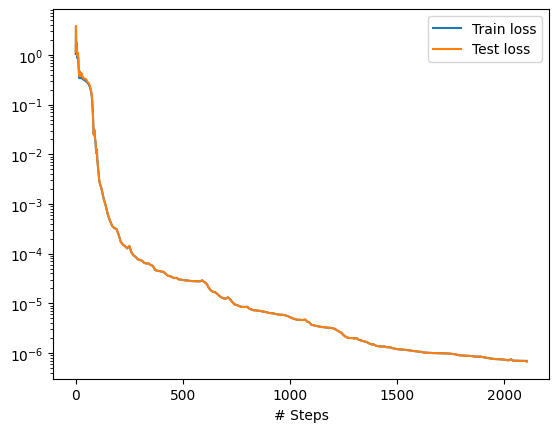

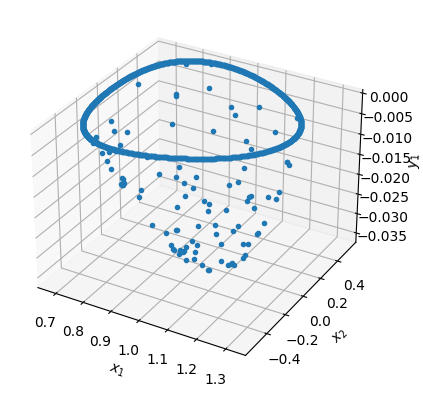

In [ ]:
# Compile, train and save model
model.compile(
    "L-BFGS-B",
    loss_weights=[1,100]
)
loss_history, train_state = model.train(
    epochs=1000, display_every=10, #callbacks=[dde.callbacks.DropoutUncertainty()]
)
dde.saveplot(
    loss_history, 
    train_state, 
    issave=True, 
    isplot=True,
    output_dir=PATH
)

(25, 25)


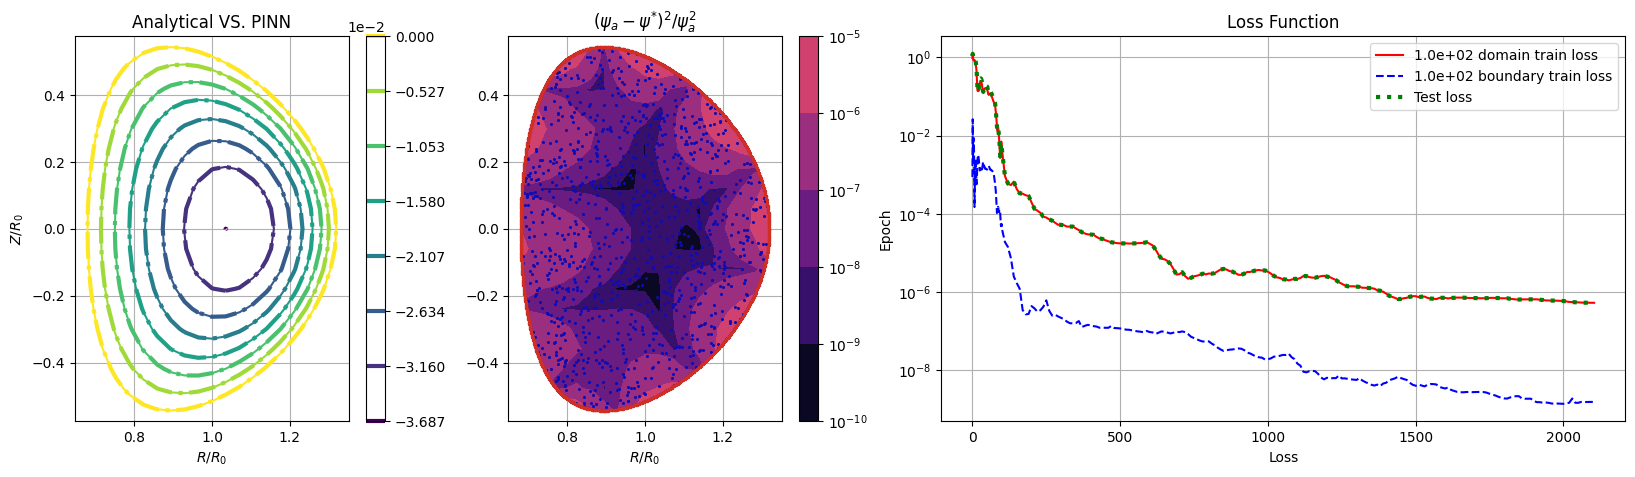

In [ ]:
# Evaluation
x, y, psi_pred, psi_true, error = evaluate(ITER, model)
# x_eq, psi_true_eq, psi_pred_eq, e_eq = evaluate_eq(ITER, model)
X_test = spatial_domain.random_points(333)
plot_summary_figure(ITER, model, X_test, losshistory = loss_history, loss_ratio = LOSSRATIO, PATH = PATH)

True volume =  0.538714633599034
predicted volume =  0.5387184060407683
True Cp =  2.769043083412222
predicted Cp =  2.769108524278789
True qstar =  1.5447070451895963
True beta_p =  1.2359998633055786
True beta_t =  0.05304276133194401
True beta =  0.05086010695268426
Predicted qstar =  1.5447435512910126
Predicted beta_p =  1.2319205758172769
Predicted beta_t =  0.052865200520878286
Predicted beta =  0.05068995116991015


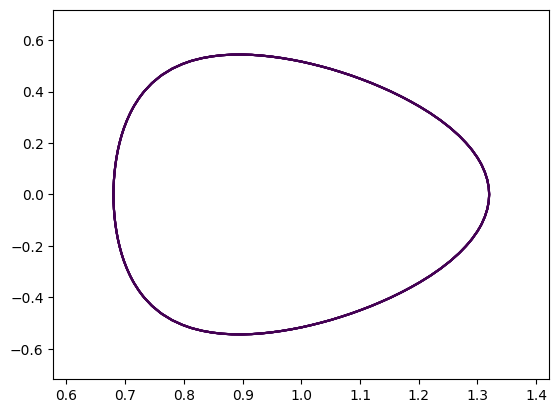

In [9]:
engineering_params = compute_params(x, y, psi_true, psi_pred)